In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
import qiskit.tools.jupyter
import math
from math import gcd
import pandas as pd
from numpy.random import randint
from fractions import Fraction
%matplotlib inline

Value from f(0) to f(r):
[1.0, 3.0, 9.0, 27.0, 11.0, 33.0, 29.0, 17.0, 16.0, 13.0, 4.0, 12.0, 1.0]


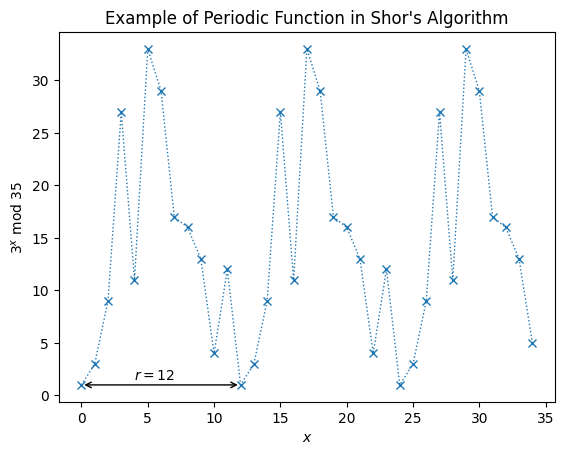

In [2]:
N = 35
a = 3

# Calculate the plotting data
xvals = np.arange(35, dtype = float)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
    print('Value from f(0) to f(r):')
    print(yvals[:r+1])
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

In [3]:
'''Qiskit_code_cell'''
# Oracle: Modular Exponentiation U^{2^j} |y> = |a^{2^j}y mod N> 
def c_amod15(a, power): # It use 4 
    """Controlled multiplication by a mod 15"""
    if a not in [2,4,7,8,11,13]:
        raise ValueError("'a' must be 2,4,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a in [4, 11]:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

# Inverse Quantum Fourier Transformation of n qubits
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

/home/dcb/Programs/miniconda/miniconda3/envs/qiskit_qibo_penny_2/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


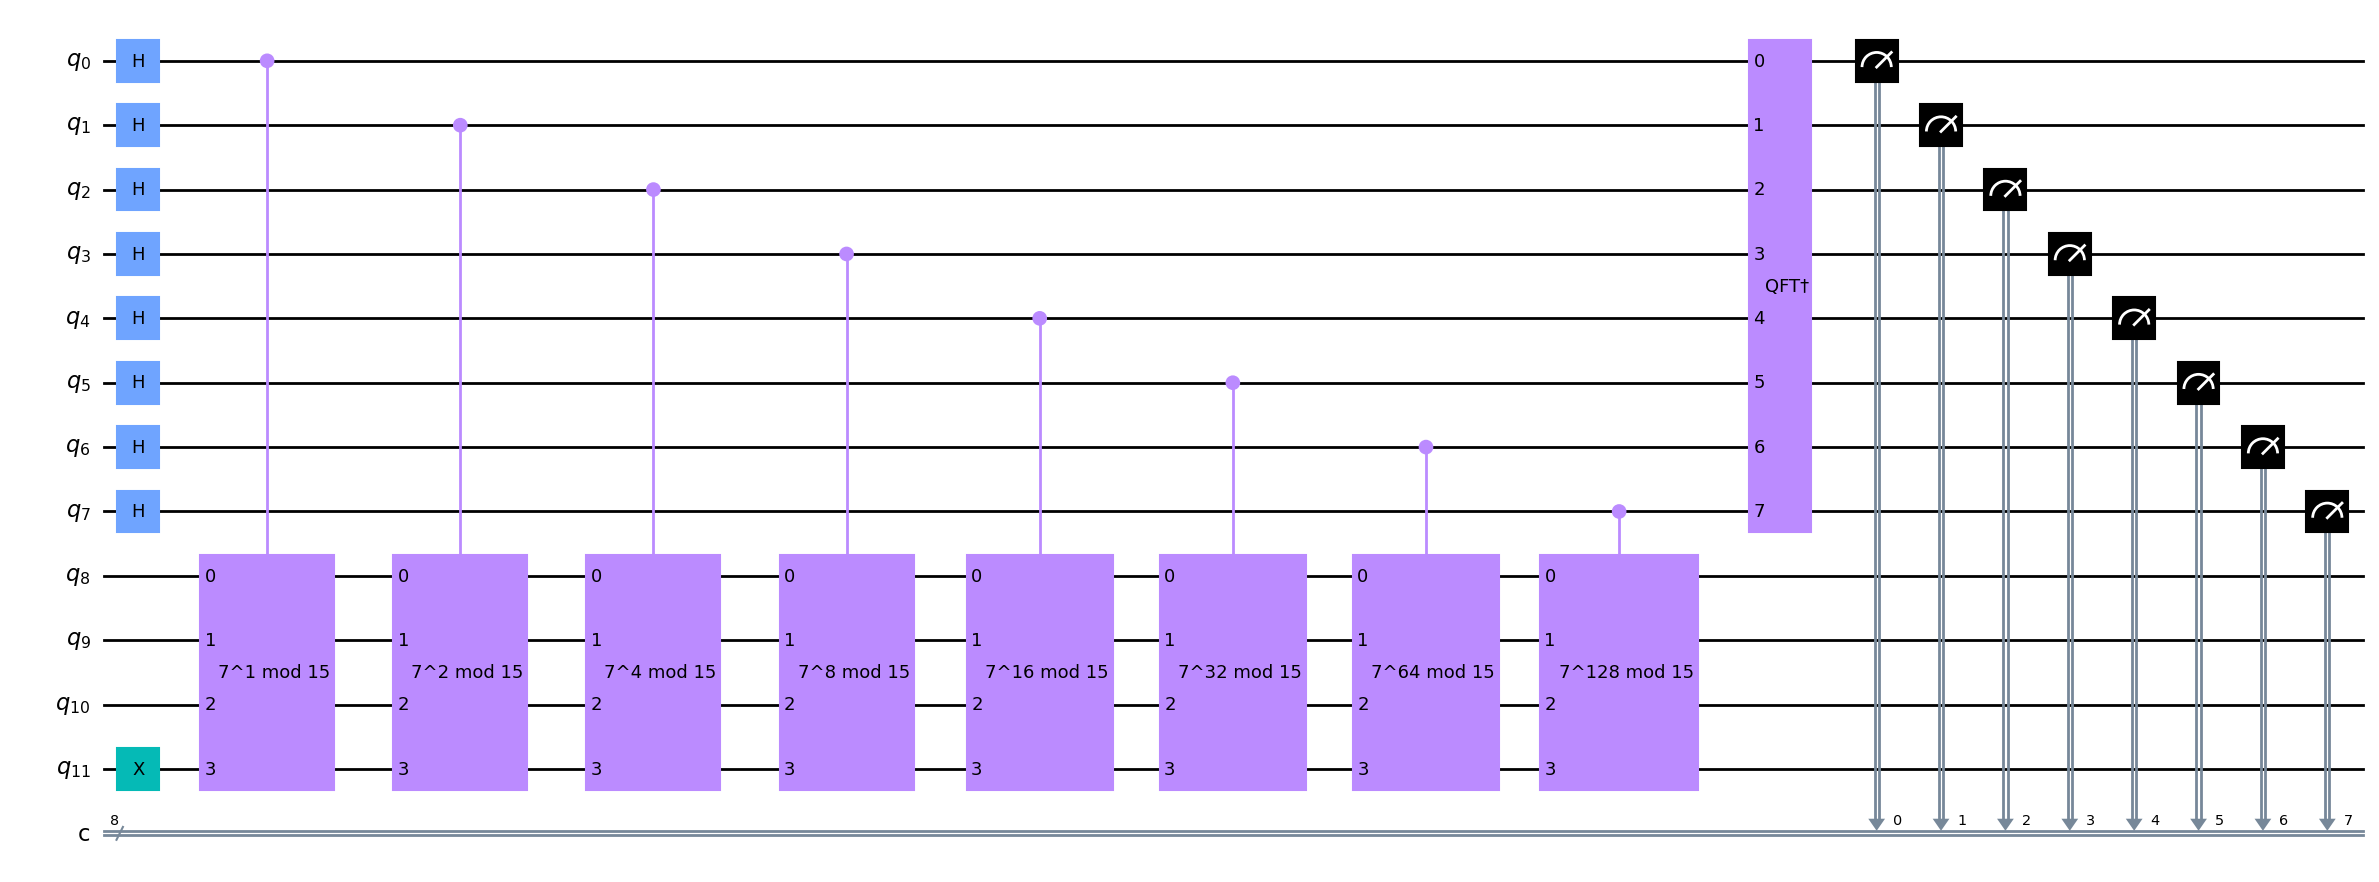

In [4]:
'''Qiskit_code_cell'''
# Specify variables
n_count = 8  # number of counting qubits
a = 7

# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(output = 'mpl', fold=-1)  # -1 means 'do not fold'

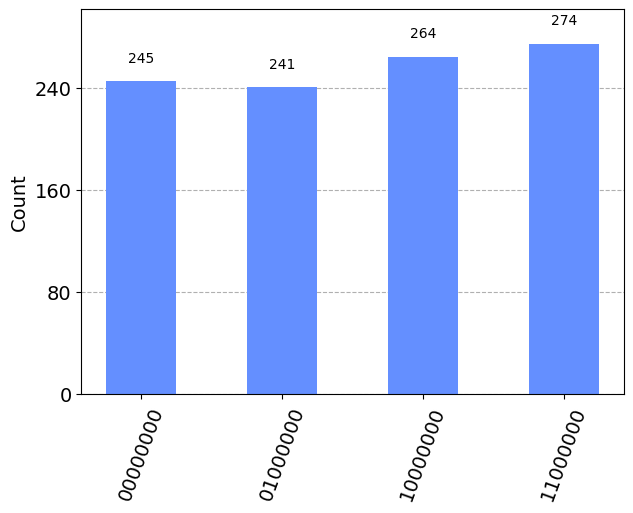

In [5]:
'''Qiskit_code_cell'''
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
results = aer_sim.run(t_qc).result()
counts = results.get_counts()
plot_histogram(counts)

In [6]:
'''Qiskit_code_cell'''
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    frac = Fraction(phase).limit_denominator(15)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{phase:.2f}",
                 f"{frac.numerator}/{frac.denominator}",
                 frac.denominator])
# Print the rows in a table
headers=["Register Output", "  Phase  ", "  Fraction  ", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

            Register Output   Phase     Fraction    Guess for r
0  00000000(bin) =   0(dec)      0.00          0/1            1
1  01000000(bin) =  64(dec)      0.25          1/4            4
2  10000000(bin) = 128(dec)      0.50          1/2            2
3  11000000(bin) = 192(dec)      0.75          3/4            4


In [7]:
# Number to be factored
N=15

In [8]:
# Choose a random number, a, between 1 and N-1
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print('a = ', a)

a =  7


In [9]:
#Next we quickly check it isn't already a non-trivial factor of N
from math import gcd # greatest common divisor
gcd(a, N)

1

In [10]:
'''Qiskit_code_cell'''
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    result = aer_sim.run(t_qc, shots=1, memory=True).result() # One shot
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [11]:
'''Qiskit_code_cell'''
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:


Register Reading: 10000000
Corresponding Phase: 0.500000
Result: r = 2
Guessed Factors: 3 and 1
*** Non-trivial factor found: 3 ***


In [12]:
%qiskit_version_table